In [6]:
import os
import sys
import pickle 
import dgl
import dill
import pickle
import pandas as pd
import numpy as np
from imp import reload
import math
import h5py
import shutil
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from itertools import chain
from sklearn.model_selection import KFold
from progiter import ProgIter
from mymodule import Trasnformer_model, VAE_model, GAE_model
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.nn.functional import binary_cross_entropy_with_logits as BCELoss

random_state=34

In [2]:
reload(GAE_model)

<module 'mymodule.GAE_model' from '/tf/notebooks/code_for_pub/mymodule/GAE_model.py'>

In [7]:
with open('/tf/notebooks/code_for_pub/smiles_files/smiles_drugcomb_BY_cid_duplicated.pickle','rb') as f:
    b = pickle.load(f)
#with open('/tf/notebooks/code_for_pub/smiles_files/smiles_drugcombANDchembl26.pickle','rb') as f:
#    b = pickle.load(f)    
smiles = b.drop_duplicates().reset_index(drop=True)

In [9]:
mols = GAE_model.smiles2mols(b)
graphs = GAE_model.mols2graphs(mols)
data = GAE_model.MolDataset(graphs)

# save mols to disk

with open('/tf/notebooks/code_for_pub/input_files/mols_drugcombonly.pkl', 'wb') as f:
    pickle.dump(mols, f)
with open("/tf/notebooks/code_for_pub/input_files/graphs_drugcombonly.pkl", "wb") as f:
    pickle.dump(graphs, f)


 4153/4153... rate=3141.87 Hz, eta=0:00:00, total=0:00:01, wall=07:10 UTC
 4153/4153... rate=532.92 Hz, eta=0:00:00, total=0:00:07, wall=07:10 UTC
Dataset includes 4153 graphs


In [11]:
with open('/tf/notebooks/code_for_pub/input_files/mols_drugcombonly.pkl', 'rb') as f:
    mols = pickle.load(f)
with open("/tf/notebooks/code_for_pub/input_files/graphs_drugcombonly.pkl", "rb") as f:
    graphs = pickle.load(f)

In [12]:
model = GAE_model.GAE(in_dim=54, activation_f=F.relu, hidden_dims=[54,46,40,34,28,22,16])
model.cuda()

trainer = GAE_model.Trainer(model,  optim='adam', lr=0.001)


Total Parameters: 10760


In [13]:
n_splits = 5
random_state = 34
n_epoch = 201
batch_s = 340
best_loss = 10
train_losses, test_losses = [], []

kf = KFold(n_splits=n_splits, shuffle=False)
for e in range(0, n_epoch):
    temp_test_losses = []
    temp_train_losses = []
    
    for ind,(train_index,test_index) in enumerate(kf.split(data)):
        train = DataLoader(Subset(data, train_index), 
                           batch_size=batch_s, 
                           shuffle=True, 
                           num_workers=6,
                           collate_fn=GAE_model.collate
                          )
        test = DataLoader(Subset(data, test_index), 
                          batch_size=batch_s, 
                          shuffle=True, 
                          num_workers=6,
                          collate_fn=GAE_model.collate
                         )
        model.train()
        train_loss = 0
        for bg in train:
            #bg.set_e_initializer(GAE_model.dgl.init.zero_initializer)
            #bg.set_n_initializer(GAE_model.dgl.init.zero_initializer)  
            train_loss += trainer.iteration(bg)
        train_loss /= len(train)
        temp_train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        for bg in test:
            #bg.set_e_initializer(GAE_model.dgl.init.zero_initializer)
            #bg.set_n_initializer(GAE_model.dgl.init.zero_initializer)  
            test_loss += trainer.iteration(bg, train=False)
        test_loss /= len(test)
        temp_test_losses.append(test_loss)
    
    train_losses.append(np.mean(temp_train_losses))
    test_losses.append(np.mean(temp_test_losses))
    if e % 50 == 0:
        print(f'epoch: {e}, train Loss:, {train_losses[-1]}, test loss: {test_losses[-1]}')
    
    loss = test_losses[-1]
    is_best = loss < best_loss
    
    if is_best:
        best_loss = loss
        trainer.scheduler.step(loss)
        trainer.save(e, '/tf/notebooks/code_for_pub/_logs_as_python_files/gae_training_logs/')
        print(f'BEST score! epoch: {e}, train Loss:, {train_losses[-1]}, test loss: {test_losses[-1]}')
    else:
        trainer.scheduler.step(loss)
    


epoch: 0, train Loss:, 1.2331466174125674, test loss: 1.2205759684244792
BEST score! epoch: 0, train Loss:, 1.2331466174125674, test loss: 1.2205759684244792
BEST score! epoch: 1, train Loss:, 1.1080327939987182, test loss: 1.1283478101094562
BEST score! epoch: 2, train Loss:, 1.0644012093544004, test loss: 1.0687947273254397
BEST score! epoch: 3, train Loss:, 1.0272483825683594, test loss: 1.038957953453064
BEST score! epoch: 4, train Loss:, 1.00755766749382, test loss: 1.023639233907064
BEST score! epoch: 5, train Loss:, 0.9916413855552673, test loss: 1.0086623708407083
BEST score! epoch: 6, train Loss:, 0.9771535575389863, test loss: 0.9950185656547547
BEST score! epoch: 7, train Loss:, 0.9658914923667907, test loss: 0.9733881314595539
BEST score! epoch: 8, train Loss:, 0.9529077577590943, test loss: 0.9667709390322367
BEST score! epoch: 9, train Loss:, 0.9475360524654388, test loss: 0.9562807202339172
BEST score! epoch: 10, train Loss:, 0.9394382834434509, test loss: 0.950220473607

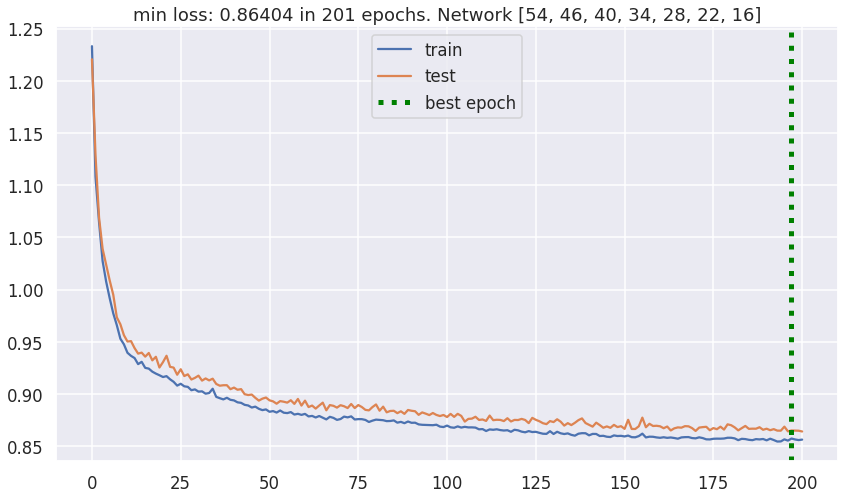

In [15]:
sns.set(style='darkgrid', context='talk')

plt.figure(figsize=(14,8))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.axvline(197,label='best epoch',c='green', lw=5, ls=':')
plt.legend()
plt.title(f'min loss: {round(best_loss,5)} in {len(test_losses)} epochs. Network {[54,46,40,34,28,22,16]}')
plt.show()

In [3]:
model = GAE_model.GAE(in_dim=54, hidden_dims=[54,45,35,31,27,23,20, 16])

device = torch.device('cpu')

PATH = '/tf/notebooks/try_GAE/gae-dgl/gae_dgl/.save/ep46'

model.load_state_dict(torch.load(PATH,map_location=device))
model.eval()

GAE(
  (layers): ModuleList(
    (0): GCN(
      (linear): Linear(in_features=54, out_features=54, bias=True)
    )
    (1): GCN(
      (linear): Linear(in_features=54, out_features=45, bias=True)
    )
    (2): GCN(
      (linear): Linear(in_features=45, out_features=35, bias=True)
    )
    (3): GCN(
      (linear): Linear(in_features=35, out_features=31, bias=True)
    )
    (4): GCN(
      (linear): Linear(in_features=31, out_features=27, bias=True)
    )
    (5): GCN(
      (linear): Linear(in_features=27, out_features=23, bias=True)
    )
    (6): GCN(
      (linear): Linear(in_features=23, out_features=20, bias=True)
    )
    (7): GCN(
      (linear): Linear(in_features=20, out_features=16, bias=True)
    )
  )
  (decoder): InnerProductDecoder()
)